In [80]:
import pandas as pd


In [81]:
import numpy as np

In [82]:
#!unzip "/content/drive/MyDrive/Colab Notebooks/dig-vision/dog-breed-identification (1).zip" -d "/content/drive/MyDrive/Colab Notebooks/dig-vision/"

# End-to-end multi class dog breed clasification

This notebook builds an end-to-end multi-class image classifier using TensorFlow and TensorFlowHub

## 1.Problem
Identifying the breed of a dog given an image of a dog.
## 2.Data
The data we are using from kaggle's dog breed identification competition
https://www.kaggle.com/competitions/dog-breed-identification/data

## 3.Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image
https://www.kaggle.com/competitions/dog-breed-identification/overview

## 4.Features
Some information about the data
* We're dealing with images (unstructured data) so it's probably best we use deep learning/ transfer learning.
* There are 120 breeds of dogs .
* There are around 10,000+ images in the training set.These images have labels
* There are around 10,000+ images in the Test set.These images have no labels


### Get our workspace ready
* Import tensorflow
* Import TensorFlow Hub
*Make sure using a GPu

In [83]:
# Import TensorFlow into colab
import tensorflow as tf
print(tf.__version__)

2.14.0


In [84]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

# Check GPU availbility
print("GPU", "availble (YES!!!!!)" if tf.config.list_physical_devices("GPU") else "not availble")

2.14.0
0.15.0
GPU not availble


## Getting our data ready (Turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors.

Let's start by accessing our data and checking out the labels


In [85]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dig-vision/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [86]:
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [87]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [88]:
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

<Axes: >

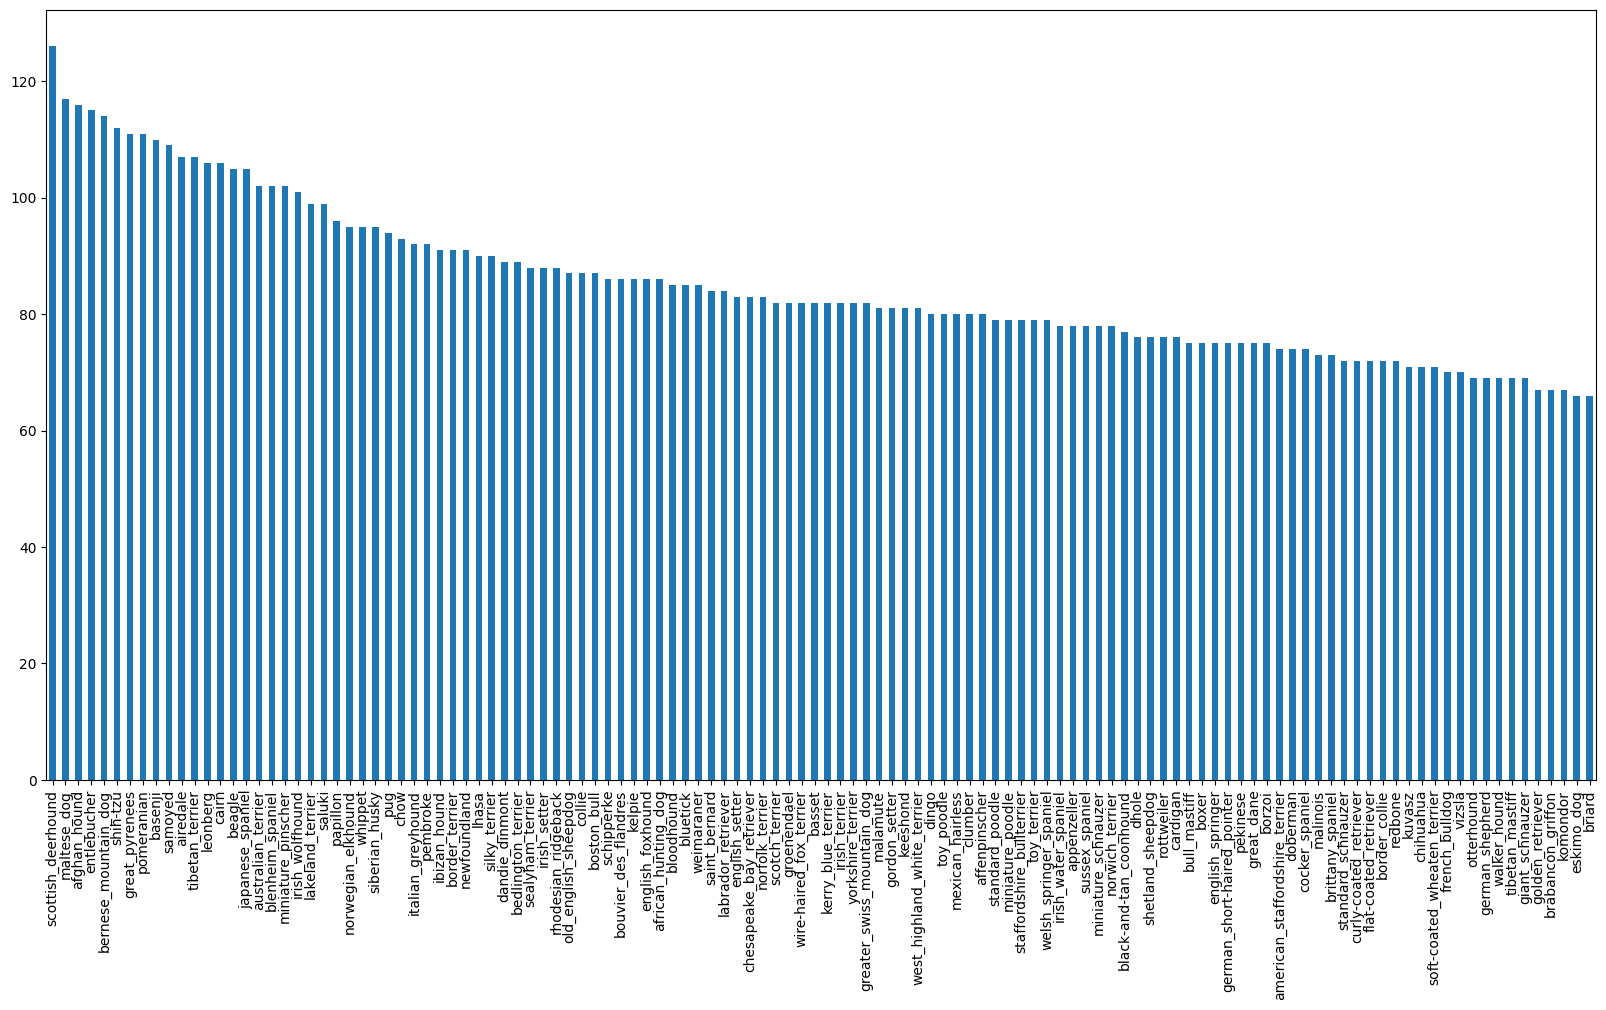

In [89]:
labels_csv["breed"].value_counts().plot(kind="bar",figsize=(20,10))

In [90]:
labels_csv["breed"].value_counts().mean()

85.18333333333334

In [91]:
labels_csv["breed"].value_counts().median()

82.0

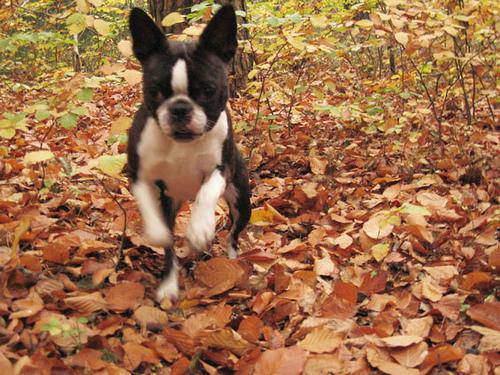

In [92]:
# Let's view an image
from IPython.display import Image
Image("/content/drive/MyDrive/Colab Notebooks/dig-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Let's get a list of all our images file and path names

In [93]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [94]:
# Create pathnames from image ID's
filenames = ["/content/drive/MyDrive/Colab Notebooks/dig-vision/train/"+fname+".jpg" for fname in labels_csv["id"]]

#Check the first 10
filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/dig-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [95]:
# Check wheather no.of filenames matches number of actual image files
len(filenames) == len(labels_csv["id"])

True

In [96]:
# Check wheather no.of filenames matches number of actual image files
import os
if len(os.listdir("/content/drive/MyDrive/Colab Notebooks/dig-vision/train/")) == len(filenames):
  print(True)
else:
  print(False)

True


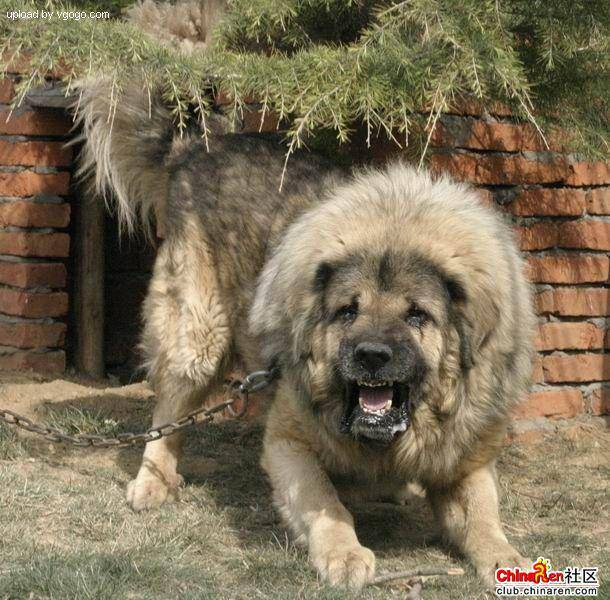

In [97]:
Image(filenames[9000])

In [98]:
labels_csv['id'][9000]

'e20e32bf114141e20a1af854ca4d0ecc'

Since We've now got our training image filepaths in a  list,  Let's prepare our labels

In [99]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [100]:
labels = labels_csv["breed"]
labels

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [101]:
import numpy as np
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [102]:
len(labels)

10222

In [103]:
# See No.of labels matches the no.of filenames
if len(labels) == len(filenames):
  print(True)
else:
  print(False)

True


In [104]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [105]:
len(unique_breeds)

120

In [106]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [107]:
# Turn every label into boolean array
boolean_labels = [ label == unique_breeds for label in labels]
boolean_labels


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [108]:
len(boolean_labels)

10222

In [109]:

# Example: Turning boolean array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) #Index where the label occurs
print(boolean_labels[0].argmax()) # Index where the label occurs in boolean array
print(boolean_labels[0].astype(int)) #there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

In [110]:
# Setup X & Y varibles
x = filenames
y= boolean_labels

We're going to start off expermenting with ~1000 images and increse as they needed

In [111]:
# Set No.of images to use for expermenting
NUM_IMAGES = 1000 #@param {type:"slider",min:1000, max:1000,step:1000}

In [112]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=42)

len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

In [113]:
# Let's have a geez at the training data
x_train[:2],y_train[:2]

(['/content/drive/MyDrive/Colab Notebooks/dig-vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fa

## Preprocessing Images (Turning images into Numbers)


In [114]:
# Converting image into NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape


(257, 350, 3)

In [115]:
image

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]

In [117]:
image.max(), image.min()

(255, 0)

In [118]:
# Turm image into tensors
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
tf.constant(image) == image

<tf.Tensor: shape=(257, 350, 3), dtype=bool, numpy=
array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  T

In [121]:
# Define image size
IMG_SIZE = 224

# Create a function for Preprocessing images
def process_image(image_path,image_size=IMG_SIZE):
  """
  Takes an image file path and turns the image intoa Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 colour channels(Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1(also calles normaliztion)
  image = tf.image.convert_image_dtype(image,tf.float32)

  # Resize the image to our desired value(224,224)
  image = tf.image.resize(image,size=[image_size, image_size])

  return image

In [122]:

tensor = tf.io.read_file(filenames[42])

In [123]:
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\x01\x01^\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [124]:
tensor = tf.image.decode_jpeg(tensor, channels=3)

In [125]:


tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(257, 350, 3), dtype=float32, numpy=
array([[[0.34509805, 0.5411765 , 0.34117648],
        [0.29411766, 0.4901961 , 0.2901961 ],
        [0.24705884, 0.43529415, 0.23137257],
        ...,
        [0.29803923, 0.5254902 , 0.32941177],
        [0.29803923, 0.5254902 , 0.3372549 ],
        [0.29411766, 0.52156866, 0.33333334]],

       [[0.2784314 , 0.47058827, 0.28627452],
        [0.25490198, 0.45098042, 0.25882354],
        [0.24313727, 0.43921572, 0.24705884],
        ...,
        [0.28627452, 0.5137255 , 0.3254902 ],
        [0.2901961 , 0.5176471 , 0.32941177],
        [0.2901961 , 0.5176471 , 0.32941177]],

       [[0.21176472, 0.41176474, 0.2509804 ],
        [0.21960786, 0.41960788, 0.25882354],
        [0.24313727, 0.4431373 , 0.28235295],
        ...,
        [0.27450982, 0.49803925, 0.32156864],
        [0.2784314 , 0.5019608 , 0.3254902 ],
        [0.28235295, 0.5058824 , 0.32941177]],

       ...,

       [[0.00784314, 0.04313726, 0.03921569],
        [0.01

## Turning out data into batches


In [126]:
# Create a simple function to return a tuple (image , label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, processes the image and returns a tuple of (image, label).

  """
  image = process_image(image_path)
  return image, label

In [127]:
#  Demo of the above
(process_image(x[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [128]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x,y=None,batch_size = BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it is's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input(no labels).
  """
  # If the data is test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # Only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),  #filepaths
                                                tf.constant(y))) #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn the filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
    # Shuffling the pathnames and labels before mapping image processor function
    data = data.shuffle(buffer_size=len(x))

    # Create (image, labels) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch



In [129]:
# Creating training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val,y_val,valid_data=True)

Creating training data batches...
Creating validation data batches..


In [130]:
# Checkout the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [131]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create a subplots (5 rows, 5 columns)
    ax=plt.subplot(5 ,5 ,i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")



In [132]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

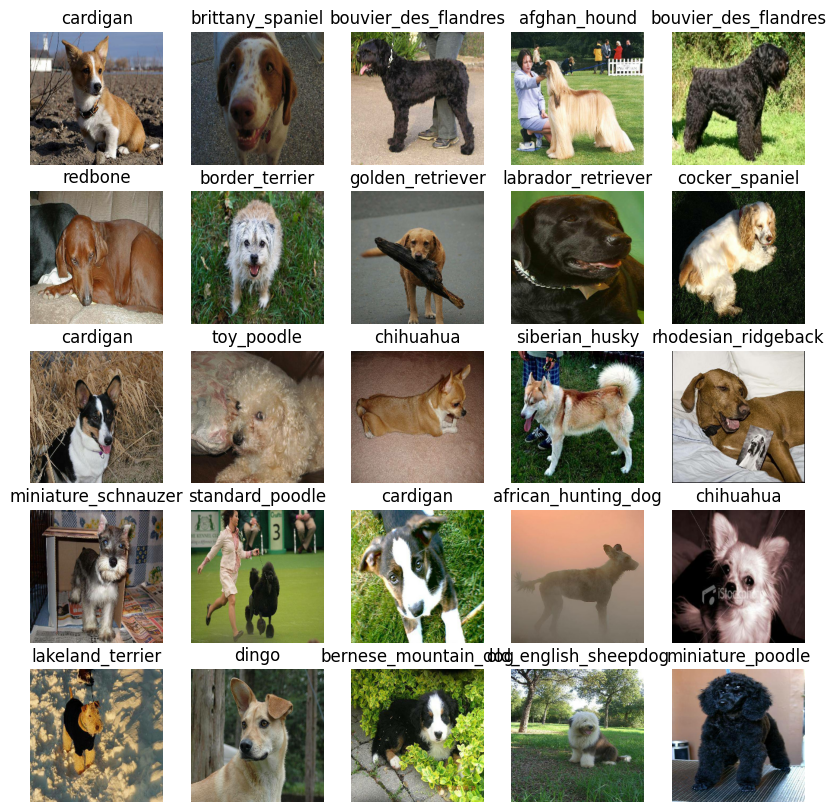

In [133]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

In [134]:
# Now let's visualize our validation set
val_images , val_labels = next(val_data.as_numpy_iterator())

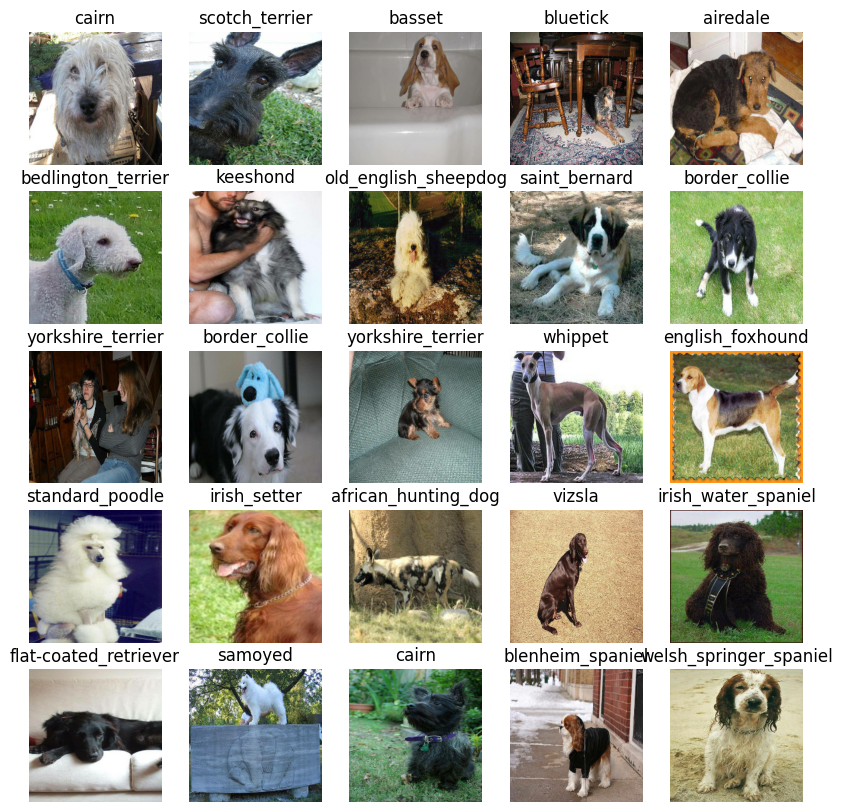

In [135]:
show_25_images(val_images , val_labels)

## Building a model

In [136]:
IMG_SIZE

224

In [137]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL =  "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [138]:
# Cretae a function ehich builds a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape= OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Buildig model with;", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
      tf.keras.layers.Dense(units= OUTPUT_SHAPE,
      activation="softmax")  # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model



In [139]:
model= create_model()
model.summary()

Buildig model with; https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating call backs

### TensorBoard callback

In [140]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [141]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  #Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Colab Notebooks/dig-vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

In [142]:
 # Create early stopping callback
 early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                   patience=3)

## Training a model


In [144]:
NUM_EPOCHS = 40 #@param {type:"slider", min:10,max:100,step:10}

Let's create a model which trains a model

* Create a model using `create_model`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit` function on our model passing it traing data, validation data, number of epochs to train (`NUM_EPOCHS`) and callbacks we'd like to use
* Return the model

In [145]:
# Build a function to train and return trained model
def train_model():
  """
  Trains a given model and returns the trained model.
  """
  # Create a model
  model= create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
             epochs= NUM_EPOCHS,
            validation_data = val_data,
             validation_freq=1,
            callbacks=[tensorboard,early_stopping])

  # Return the fitted model
  return model


In [ ]:
model = train_model()

Buildig model with; https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/40
25/25 [==============================] - 59s 2s/step - loss: 4.5105 - accuracy: 0.0925 - val_loss: 3.4411 - val_accuracy: 0.2400
Epoch 2/40
25/25 [==============================] - 46s 2s/step - loss: 1.5911 - accuracy: 0.7013 - val_loss: 2.2140 - val_accuracy: 0.4850
Epoch 3/40
25/25 [==============================] - 47s 2s/step - loss: 0.5611 - accuracy: 0.9350 - val_loss: 1.7217 - val_accuracy: 0.5850
Epoch 4/40
25/25 [==============================] - 47s 2s/step - loss: 0.2493 - accuracy: 0.9875 - val_loss: 1.5513 - val_accuracy: 0.6350
Epoch 5/40
25/25 [==============================] - 45s 2s/step - loss: 0.1465 - accuracy: 0.9975 - val_loss: 1.4629 - val_accuracy: 0.6450
Epoch 6/40
25/25 [==============================] - 45s 2s/step - loss: 0.1002 - accuracy: 1.0000 - val_loss: 1.4020 - val_accuracy: 0.6600
Epoch 7/40
25/25 [==============================] - 47s 2s/step - lo

### Checking the TensorBoard logs

In [ ]:
%tensorboard --logdir drive/MyDrive/Colab\ Notebooks/dig-vision/logs --port 6008


<IPython.core.display.Javascript object>

In [ ]:
from tensorboard import notebook


In [ ]:
%tensorboard --logdir drive/MyDrive/Colab\ Notebooks/dig-vision/logs --port 6009


<IPython.core.display.Javascript object>

In [ ]:
%tensorboard --logdir drive/MyDrive/Colab\ Notebooks/dig-vision/logs --port 6011

<IPython.core.display.Javascript object>

In [ ]:
!rm -rf ./logs/



## Making and evaluating predictions using trained model

In [146]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Make predictions on the validation data (not used to train)
predictions = model.predict(val_data,verbose=1)
predictions

7/7 [==============================] - 47s 1s/step


array([[3.2775400e-03, 2.9396216e-04, 7.8295841e-04, ..., 3.2743550e-04,
        3.4520926e-05, 5.1442641e-03],
       [6.9140166e-04, 9.1914315e-04, 6.0257442e-02, ..., 6.6579302e-04,
        5.5840024e-04, 2.0096064e-04],
       [3.7878381e-05, 1.5680341e-04, 6.2612322e-05, ..., 7.6914323e-04,
        3.7931375e-05, 1.0209106e-04],
       ...,
       [1.3458837e-05, 1.6076412e-05, 1.3415447e-05, ..., 2.5145150e-06,
        2.2336924e-05, 3.6707479e-05],
       [6.2969001e-03, 2.0037124e-04, 1.1831378e-04, ..., 1.0519915e-04,
        1.0250039e-04, 1.1589284e-02],
       [7.0256373e-04, 3.6049732e-05, 5.8674981e-04, ..., 1.1829991e-03,
        4.8089854e-04, 5.7939320e-05]], dtype=float32)

In [ ]:
predictions[0]

array([3.2775400e-03, 2.9396216e-04, 7.8295841e-04, 2.7912622e-04,
       3.7682580e-04, 4.7641694e-05, 4.2359646e-02, 9.0303057e-04,
       1.5997581e-04, 2.3016357e-03, 1.2574584e-03, 2.8621787e-04,
       1.0575640e-03, 1.2392768e-04, 1.7802385e-03, 1.1022356e-03,
       1.1054906e-04, 9.6249662e-02, 3.0033691e-05, 4.8969610e-04,
       1.3807061e-03, 2.1111853e-04, 4.9527054e-05, 2.5198983e-03,
       1.0399420e-03, 8.7035168e-04, 1.4381273e-01, 1.6755330e-04,
       1.2853184e-03, 2.3391990e-04, 1.3254942e-05, 1.2392609e-03,
       1.4379332e-03, 2.6663611e-04, 1.7426060e-04, 1.9165263e-02,
       1.7614716e-04, 5.5903697e-04, 6.0512433e-05, 2.9015611e-04,
       5.8595412e-03, 2.5245961e-05, 1.4849298e-04, 2.1387222e-04,
       2.9201046e-05, 4.8543300e-04, 2.8982560e-05, 2.0418820e-04,
       5.9835968e-04, 4.6819978e-04, 1.9493808e-04, 2.2962443e-04,
       2.9512378e-04, 2.7630324e-04, 4.8245388e-04, 5.2346328e-05,
       4.2566011e-04, 3.3135153e-03, 1.2302620e-04, 8.8582925e

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(y_val)

200

In [ ]:
len(unique_breeds)

120

In [ ]:
len(predictions[0])

120

In [ ]:
np.sum(predictions[0])

1.0

In [ ]:
np.sum(predictions[1])

1.0

In [ ]:
# First prediction
index=42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum :{np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[5.89157629e-04 9.70507972e-05 2.97022016e-05 2.77542567e-05
 2.81478418e-03 2.69816897e-04 2.50407844e-04 4.21427336e-04
 4.55412222e-03 2.63696741e-02 1.19891694e-04 1.53825913e-05
 2.73781188e-04 2.87580676e-03 4.21887758e-04 8.04736745e-03
 2.31247304e-05 5.63278561e-04 4.54103829e-05 3.67949862e-04
 2.04647440e-05 1.10039208e-03 5.92360775e-05 1.23579966e-05
 1.03771845e-02 1.74752509e-04 1.38520782e-05 9.06888090e-05
 7.70033803e-05 3.43919601e-05 1.00800091e-04 6.97168871e-04
 7.02676698e-05 8.30248537e-05 3.62040373e-05 1.02012222e-04
 9.65068102e-05 9.72033595e-04 3.83653969e-05 4.43327457e-01
 6.11406213e-05 1.04903565e-05 2.54660682e-03 8.22766378e-06
 7.82844436e-05 1.04901264e-05 2.16868313e-04 1.04811021e-04
 6.72911483e-06 1.31101508e-04 5.46644260e-05 8.28979537e-05
 1.18600507e-03 1.46264979e-03 8.34452439e-05 2.85114482e-04
 2.79978645e-04 1.55584494e-04 3.06765578e-04 3.21283296e-05
 1.64440553e-05 6.41991443e-04 3.99617647e-06 6.65042462e-05
 1.37613504e-04 4.278002

Having the above functionality is great but we want to be able to do it at scale

And it would be even better if we could see the image prediction is being made on.

**Note** Prediction probabilites are also known as confidence levels

In [147]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into label.
  """

  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_labels = get_pred_label(predictions[81])
pred_labels

'dingo'

In [148]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

Now since our validation data is still in a batch dataset, we have to unbatch it to make predictions on the validation images and then compare those predictions to the validation labels(truth labels)

In [149]:
# Create a function a batch dataset
def unbatchify(data):
  """
  Takes the batched dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images= []
  labels= []
  # loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator() :
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

# Unbatch the validation data
val_images, val_labels = unbatchify(val_data)


In [150]:
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
get_pred_label(val_labels[0])

'affenpinscher'

In [ ]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(unique_breeds[np.argmax(label)])

images_[0], labels_[0]


(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:

get_pred_label(labels_[0])

'affenpinscher'

Now we got ways to get :
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make a function to make these all a bit more visualize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer
* Convert the prediction probalities to a predicted label
* Plot the predicted label, its predicted probalbility, the truth label and target image on a single plot

In [151]:
def plot_pred(predicted_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label,image = predicted_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot the image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color  of title depending on if prediction is right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color="red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, true_label),color=color)



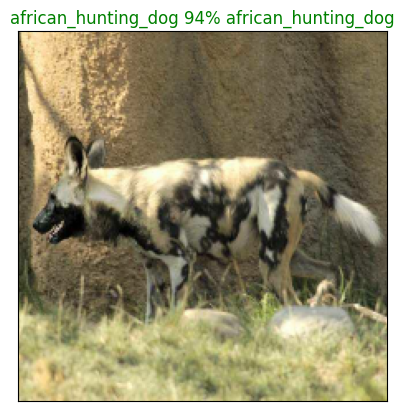

In [152]:
plot_pred(predicted_probabilities= predictions,
          labels= val_labels,
           images= val_images,n=17)

In [153]:
 def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidence along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes  = pred_prob.argsort()[-10:][::-1]
  # Find the prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color ="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)), labels = top_10_pred_labels, rotation = "vertical")

  # Change the color true labels
  if np.isin(true_label, top_10_pred_labels):

    top_plot[np.argmax(top_10_pred_labels==true_label)].set_color("green")
  else:

    pass




In [ ]:
plot_pred_conf(prediction_probabilities=predictions, labels = val_labels, n=9)

Now we've got some functions to help us visualize our prediction and evaluate our mode, let's check out a few

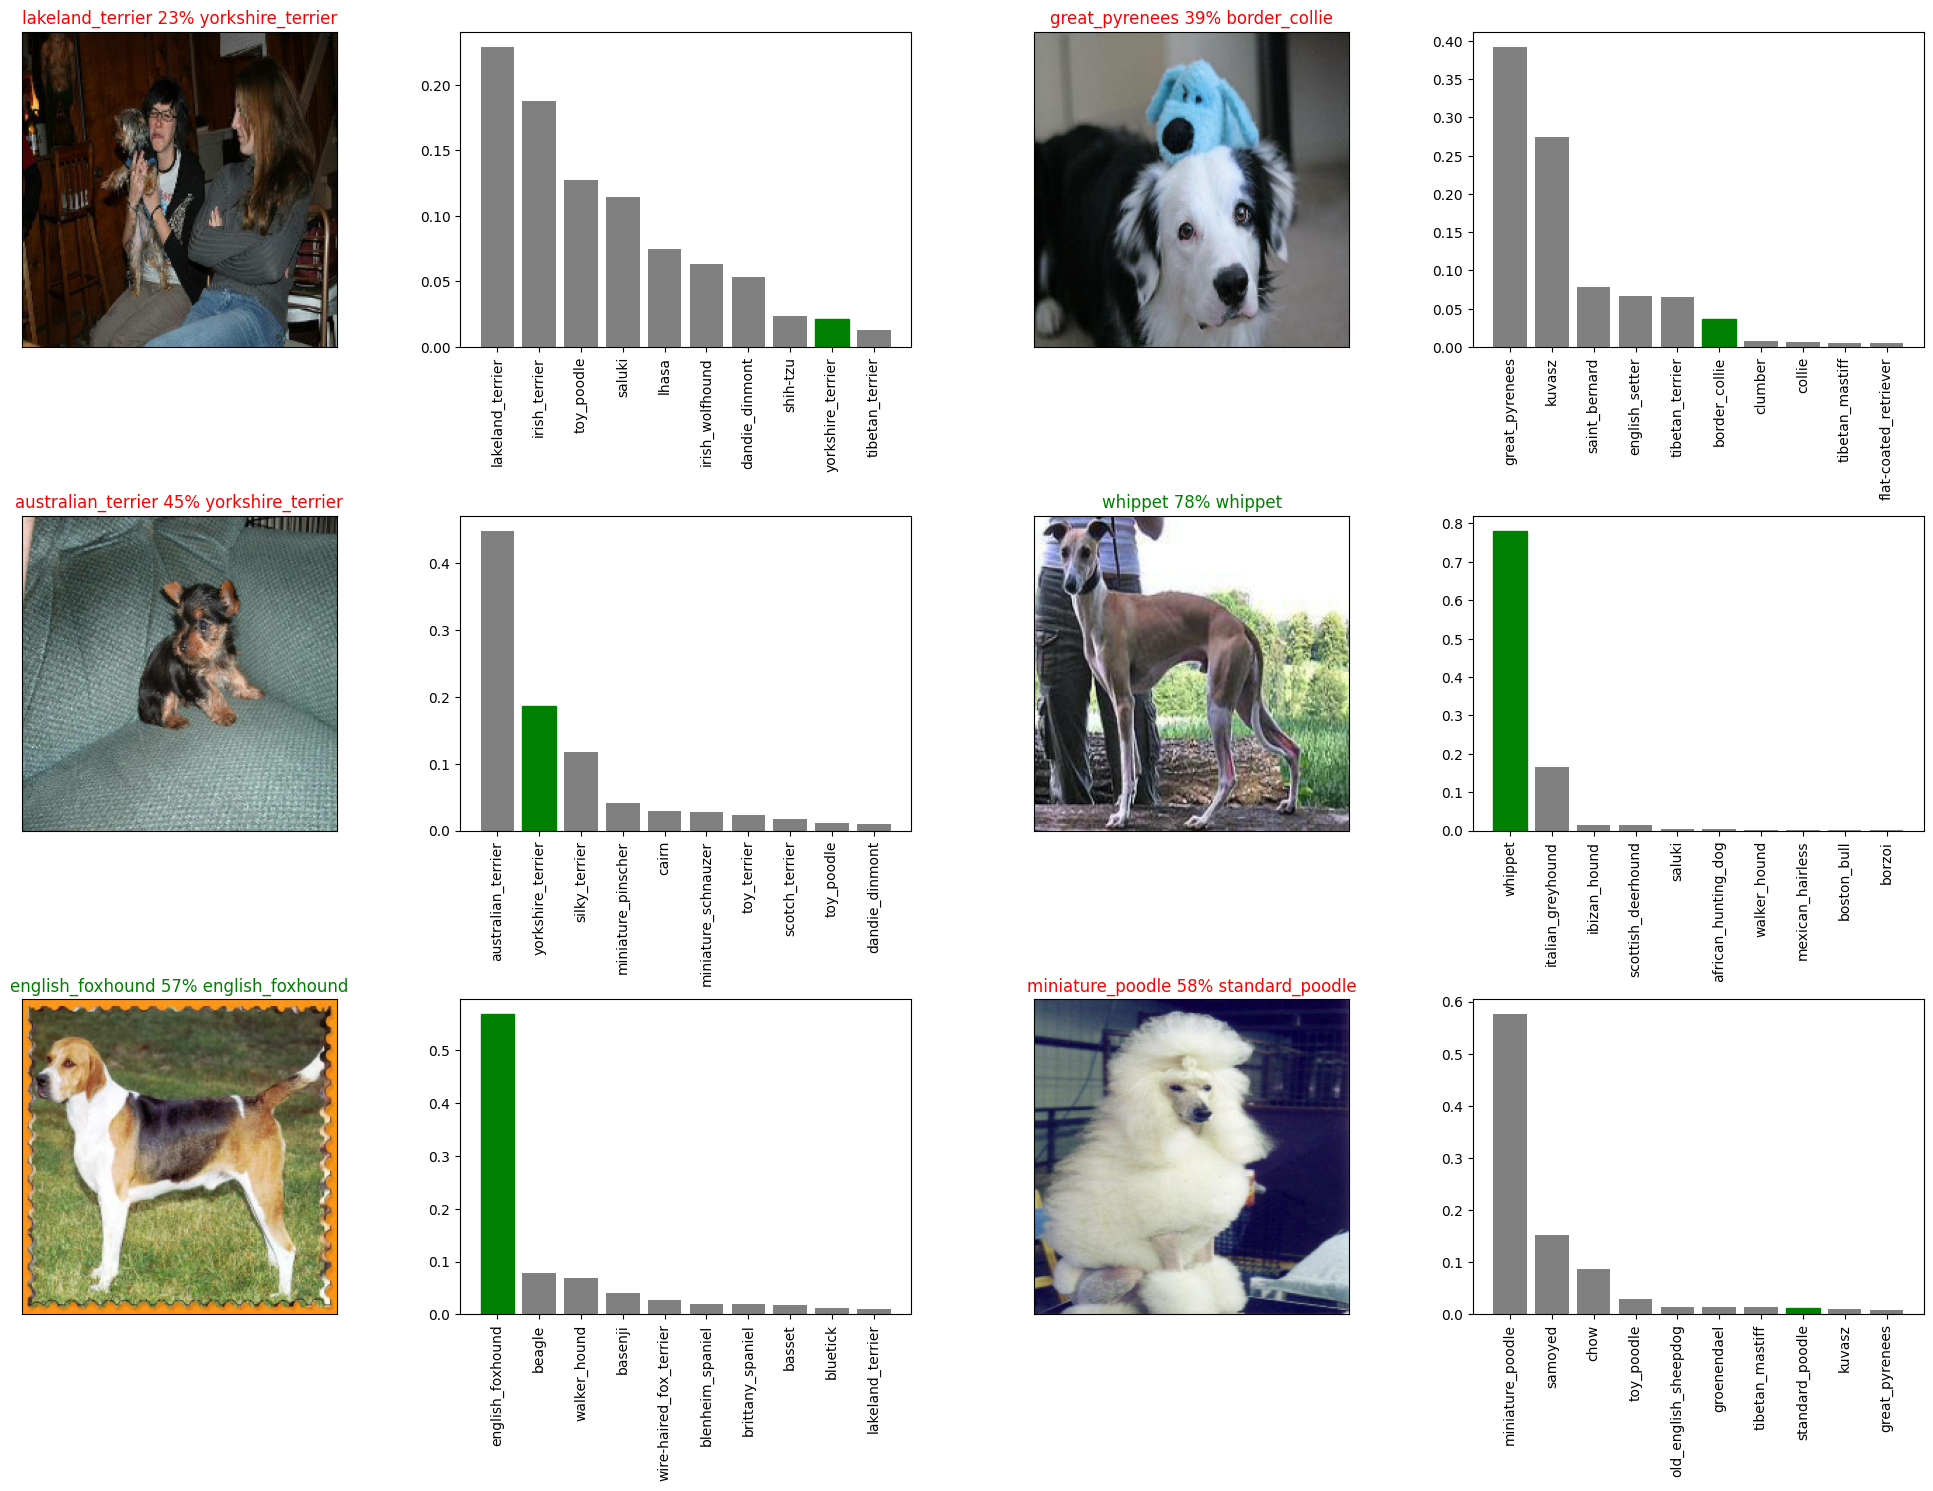

In [154]:
# Let's checkout a few predictions and their different values
i_multiplier = 10
num_rows=3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize= (10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(predicted_probabilities=predictions,
            labels= val_labels,
            images= val_images,
            n = i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
            labels= val_labels,
            n = i+i_multiplier)
plt.tight_layout(h_pad =1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our model predictions and true labels?

## Saving and reloading the model

In [155]:
# Crete a function to save a model
def save_model(model, suffix=None):
  """
  Saves a model in a models directory and appends a suffix (String)
  """

  # Create a model directory pathname with current time
  modeldir = os.path.join("/content/drive/MyDrive/Colab Notebooks/dig-vision/model", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" +suffix +".h5" # Save format of model
  print(f"Saving model to :{model_path}...")
  model.save(model_path)

  return model_path

In [156]:
# Create function to load a model
def load_model(model_path):
  """
  LOads a saved model from specified path
  """
  print(f"Loading savrd model from :{model_path}")
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer": hub.KerasLayer})
  return model


In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")


Saving model to :/content/drive/MyDrive/Colab Notebooks/dig-vision/model/20231026-13501698328233-1000-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Colab Notebooks/dig-vision/model/20231026-13501698328233-1000-images-mobilenetv2-Adam.h5'

In [157]:
# Load the trained model
loaded_1000_image_model = load_model("/content/drive/MyDrive/Colab Notebooks/dig-vision/model/20231026-5H501698313851-1000-images-mobilenetv2-Adam.h5")

Loading savrd model from :/content/drive/MyDrive/Colab Notebooks/dig-vision/model/20231026-5H501698313851-1000-images-mobilenetv2-Adam.h5


In [158]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 10s 1s/step - loss: 5.7827 - accuracy: 0.0300


[5.782739639282227, 0.029999999329447746]

In [ ]:
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 105ms/step - loss: 1.2586 - accuracy: 0.6600


[1.258620023727417, 0.6600000262260437]

## Let's training a model on full data

In [159]:
len(x), len(y)

(10222, 10222)

In [160]:
x[:10]

['/content/drive/MyDrive/Colab Notebooks/dig-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [161]:
# Create a databatch eith full dataset
full_data = create_data_batches(x,y)

Creating training data batches...


In [162]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [163]:
# Create a model for full model
full_model = create_model()

Buildig model with; https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [164]:
# Create a fullmodel callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when traininig on all the data, so can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience =3)

**Note:** Running the cell below will take a little while (maybe upto 30 minites for the first epoch) because the GPU we're using in the runtime has to load all of images into memory.

In [ ]:
# Fit the full modelon full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/40
320/320 [==============================] - 3947s 12s/step - loss: 1.3429 - accuracy: 0.6705
Epoch 2/40
320/320 [==============================] - 29s 92ms/step - loss: 0.3963 - accuracy: 0.8820
Epoch 3/40
320/320 [==============================] - 29s 89ms/step - loss: 0.2342 - accuracy: 0.9367
Epoch 4/40
320/320 [==============================] - 29s 91ms/step - loss: 0.1518 - accuracy: 0.9656
Epoch 5/40
320/320 [==============================] - 29s 90ms/step - loss: 0.1036 - accuracy: 0.9793
Epoch 6/40
320/320 [==============================] - 29s 91ms/step - loss: 0.0773 - accuracy: 0.9865
Epoch 7/40
320/320 [==============================] - 29s 90ms/step - loss: 0.0587 - accuracy: 0.9913
Epoch 8/40
320/320 [==============================] - 29s 90ms/step - loss: 0.0462 - accuracy: 0.9948
Epoch 9/40
320/320 [==============================] - 28s 89ms/step - loss: 0.0371 - accuracy: 0.9960
Epoch 10/40
320/320 [==============================] - 29s 90ms/step - loss: 0.03

In [ ]:
save_model(full_model, suffix = "full-image-set-mobilenetv2-Adam")

Saving model to :/content/drive/MyDrive/Colab Notebooks/dig-vision/model/20231026-15361698334568-full-image-set-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/Colab Notebooks/dig-vision/model/20231026-15361698334568-full-image-set-mobilenetv2-Adam.h5'

In [165]:
# Load in the full model
loaded_full_model= load_model("/content/drive/MyDrive/Colab Notebooks/dig-vision/model/20231026-15361698334568-full-image-set-mobilenetv2-Adam.h5")

Loading savrd model from :/content/drive/MyDrive/Colab Notebooks/dig-vision/model/20231026-15361698334568-full-image-set-mobilenetv2-Adam.h5


In [ ]:
len(x)

10222

## Making predictions on the test data set

Since our model has been trained on images in the form of tensor batches, to make predictions on test data, we have to get it into the same format

In [ ]:
# Load test image file names
test_path= "/content/drive/MyDrive/Colab Notebooks/dig-vision/test/"
test_filenames= [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

In [ ]:
len(test_filenames)

In [ ]:
# create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Make predictions on the test data using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

324/324 [==============================] - 233s 673ms/step


In [ ]:
# Save predictions (Numpy array) to csv file (for access later)
np.savetxt("/content/drive/MyDrive/Colab Notebooks/dig-vision/preds_array.csv", test_predictions, delimiter = ",")

In [ ]:
# Load predictions (Numpy array) from csv file
test_predictions = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/dig-vision/preds_array.csv", delimiter=',')

In [166]:
test_predictions[:10]

array([[4.18934007e-07, 2.87172825e-05, 2.17234515e-08, ...,
        2.91468472e-09, 1.70058524e-06, 1.57509348e-07],
       [2.21076988e-07, 2.03867899e-06, 3.81011034e-07, ...,
        2.75251679e-08, 5.65344544e-06, 1.82410281e-06],
       [1.38073695e-08, 1.80086154e-12, 1.23722197e-08, ...,
        9.29335719e-09, 7.02781652e-11, 1.98316161e-06],
       ...,
       [4.47648381e-06, 1.68642289e-09, 1.39024978e-08, ...,
        3.64695403e-08, 2.95800895e-09, 6.42385034e-09],
       [7.58554135e-13, 6.15086107e-13, 4.20651514e-10, ...,
        6.19496052e-11, 3.41184849e-12, 3.95283112e-10],
       [1.35764219e-12, 9.10983008e-12, 1.31177160e-13, ...,
        1.32209660e-11, 4.68584511e-11, 1.00928554e-12]])

In [ ]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle



In [ ]:
test_predictions

array([[4.18934007e-07, 2.87172825e-05, 2.17234515e-08, ...,
        2.91468472e-09, 1.70058524e-06, 1.57509348e-07],
       [2.21076988e-07, 2.03867899e-06, 3.81011034e-07, ...,
        2.75251679e-08, 5.65344544e-06, 1.82410281e-06],
       [1.38073695e-08, 1.80086154e-12, 1.23722197e-08, ...,
        9.29335719e-09, 7.02781652e-11, 1.98316161e-06],
       ...,
       [1.11128181e-11, 2.17415905e-10, 1.48645170e-12, ...,
        2.90382629e-09, 2.44732109e-06, 3.27262419e-11],
       [4.40261756e-05, 6.96782349e-03, 2.07175361e-08, ...,
        4.79262177e-08, 3.27673121e-07, 3.71988271e-08],
       [4.42056738e-08, 2.44589735e-08, 2.07709949e-04, ...,
        3.09804484e-04, 2.38441498e-06, 5.96278596e-06]])

In [ ]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))


In [ ]:
# Append test image ID's to prediction DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

In [ ]:
test_ids

['e5507ebc0e05513bf543e160a484666f',
 'e2faaf5e760a6189d0980e6355864b4c',
 'e1f9be3ecf0409189486c786ff4bd65a',
 'e6a5c18da7beedb1622bf7d18b452121',
 'de9a61a532241cff14e732f43b646d9a',
 'e50319e7efc447bb684fbfdbed3ff041',
 'e30a97eb637239e3b15c903529e04800',
 'e64296ffbae301f86c8728834c507cb6',
 'de15c21ba0a1f139d26223d5e2b09703',
 'e43f6e621469f438f351d31d889b839f',
 'e39be68f3200f0ecde589e571ae6df06',
 'ee45e29f0dfdc67fdb2939df8bf10b76',
 'f10241d199251db359961e814733efc5',
 'f3d2b254424ab99c267abc3ab22ba627',
 'f41a03e617bde76fef19ec1cf1355d59',
 'ea4a775ecbf81b2cd2967cc34ce4e52b',
 'f58a21665136bb6aa4aa90c485be4315',
 'f49dbff2463687f867bfe1bc88f0a7c3',
 'ebf3e1d5583ceff0a51a8c6a750b367b',
 'eb9e89f5c0f1717f290360fec6f2a160',
 'f3d5aa14bae0561b6b9146d7e7fa0917',
 'eef2fd5db98424ae214e176a910e9e3b',
 'f3ad6585619f3489fe3c01b4e305f70b',
 'eec95c3af45f0072116b7b310fd53699',
 'ed7c3126f50898ce02c08a380c1d0bbc',
 'ef4b59cdb6485917a71f2c40df9c8d47',
 'e8319b1410a984291d71a3e60c84d86c',
 

In [ ]:
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

id affenpinscher afghan_hound  \
0  e5507ebc0e05513bf543e160a484666f           NaN          NaN   
1  e2faaf5e760a6189d0980e6355864b4c           NaN          NaN   
2  e1f9be3ecf0409189486c786ff4bd65a           NaN          NaN   
3  e6a5c18da7beedb1622bf7d18b452121           NaN          NaN   
4  de9a61a532241cff14e732f43b646d9a           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [ ]:
# Add the prediction probabilities to each to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

In [ ]:
preds_df.head()


id  affenpinscher  afghan_hound  \
0  e5507ebc0e05513bf543e160a484666f   4.189340e-07  2.871728e-05   
1  e2faaf5e760a6189d0980e6355864b4c   2.210770e-07  2.038679e-06   
2  e1f9be3ecf0409189486c786ff4bd65a   1.380737e-08  1.800862e-12   
3  e6a5c18da7beedb1622bf7d18b452121   1.388770e-10  4.275242e-10   
4  de9a61a532241cff14e732f43b646d9a   1.239143e-05  1.528452e-05   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         2.172345e-08  9.742105e-07                    2.673650e-09   
1         3.810110e-07  1.632641e-06                    9.237555e-09   
2         1.237222e-08  5.834989e-13                    2.922754e-11   
3         2.169780e-10  6.543515e-11                    7.128056e-10   
4         3.066258e-08  3.315330e-06                    5.401356e-09   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  1.705127e-10        1.007256e-11  5.436122e-09  1.312429e-09  ...   
1  4.895811e-09        3.272399e-09  1.249833e-09  2.395619e-08  ...   
2  2.987524e-08        1.138694e-08  1.201910e-07  4.252476e-11  ...   
3  5.245759e-12        1.315905e-09  2.187600e-12  8.304173e-10  ...   
4  1.781175e-09        3.420507e-05  3.757567e-08  8.404580e-10  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  1.494604e-06  6.626927e-11  4.897891e-09  1.990784e-09  8.929538e-11   
1  7.245766e-11  3.279565e-09  7.321473e-07  2.247463e-02  4.834012e-06   
2  1.531819e-07  1.848134e-05  4.362990e-10  2.850737e-12  6.687217e-10   
3  9.606116e-09  6.565418e-11  1.290990e-09  4.581002e-07  4.090791e-11   
4  3.663066e-07  2.910058e-07  7.946096e-08  1.173170e-06  1.216640e-09   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            3.482183e-10                 1.369648e-10  2.914685e-09   
1            5.668419e-07                 4.933123e-05  2.752517e-08   
2            1.097191e-08                 7.225642e-10  9.293357e-09   
3            5.145936e-08                 2.484274e-10  1.027394e-09   
4            7.974047e-08                 1.036514e-08  1.340378e-07   

   wire-haired_fox_terrier  yorkshire_terrier  
0             1.700585e-06       1.575093e-07  
1             5.653445e-06       1.824103e-06  
2             7.027817e-11       1.983162e-06  
3             7.337056e-12       9.596831e-09  
4             2.851934e-07       9.444847e-08  

[5 rows x 121 columns]

In [ ]:
# Save our predictions dataframe to csv for submission to Kaggle
preds_df.to_csv("/content/drive/MyDrive/Colab Notebooks/dig-vision/full_model_predictions_submission_1_mobilenetv2.csv", index= False)

In [ ]:
preds_df.head()

NameError: ignored

## Making predictions on custom images

 To make predictions on the custom images

In [173]:
# Let's get custom image file paths
custom_path ="/content/drive/MyDrive/Colab Notebooks/dig-vision/myDog photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [174]:
custom_image_paths

['/content/drive/MyDrive/Colab Notebooks/dig-vision/myDog photos/DOG2.jpeg',
 '/content/drive/MyDrive/Colab Notebooks/dig-vision/myDog photos/DOG1.jpg']

In [175]:
# Turn custom images into data batches
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [177]:
# Make predictions on custom data
custom_preds = loaded_full_model.predict(custom_data)
custom_preds

1/1 [==============================] - 3s 3s/step


array([[2.23771895e-06, 7.75905590e-11, 1.32809621e-08, 3.20745969e-12,
        1.28085212e-05, 5.25853139e-10, 7.03836747e-07, 2.84751192e-08,
        5.01575954e-08, 8.73184547e-08, 1.45176514e-07, 9.53782546e-07,
        1.84109652e-07, 2.51101824e-08, 1.03218302e-10, 2.92674383e-08,
        9.79609194e-09, 2.98600912e-06, 1.79359860e-09, 2.87456592e-09,
        2.41888856e-08, 2.65639017e-07, 2.78129502e-08, 2.25835572e-10,
        4.34698357e-08, 7.51275930e-09, 8.19117716e-08, 3.08316110e-08,
        2.17650662e-08, 1.01049579e-07, 2.37490305e-10, 1.80002229e-04,
        5.87859752e-08, 1.24552077e-10, 8.69291512e-07, 1.47194020e-03,
        2.04700923e-10, 9.91943680e-12, 5.01198638e-10, 7.01960801e-08,
        1.54379097e-06, 2.00613623e-08, 9.55776125e-10, 4.33221320e-10,
        3.34314592e-07, 4.61595573e-06, 2.30117956e-11, 7.45576259e-08,
        3.93733851e-10, 1.56456927e-08, 8.31856273e-09, 7.09914558e-11,
        8.59283062e-08, 3.61504569e-08, 4.26627889e-09, 6.192696

In [178]:
custom_preds.shape

(2, 120)

In [183]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['maltese_dog', 'labrador_retriever']

In [185]:
# Get custom images (our unbatchify() won't work sincr there arent labels... )
custom_images = []
# Loop through unabactched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

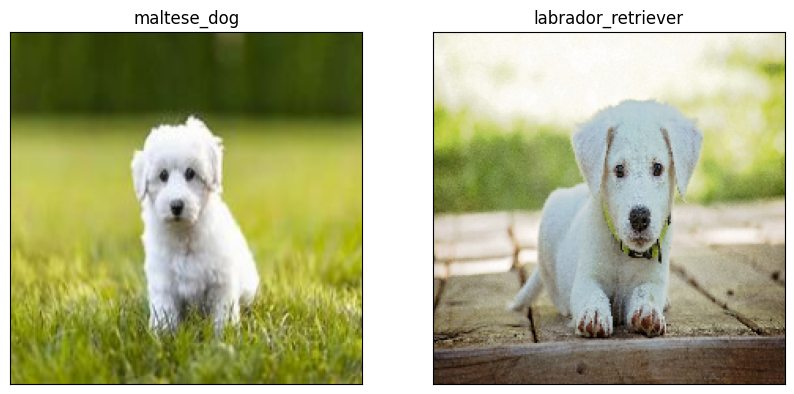

In [186]:
# Check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)